In [ ]:
#!pip3 install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Монотонность -  True
RMSE тестовой выборки LinearRegression:  21.71809246340824


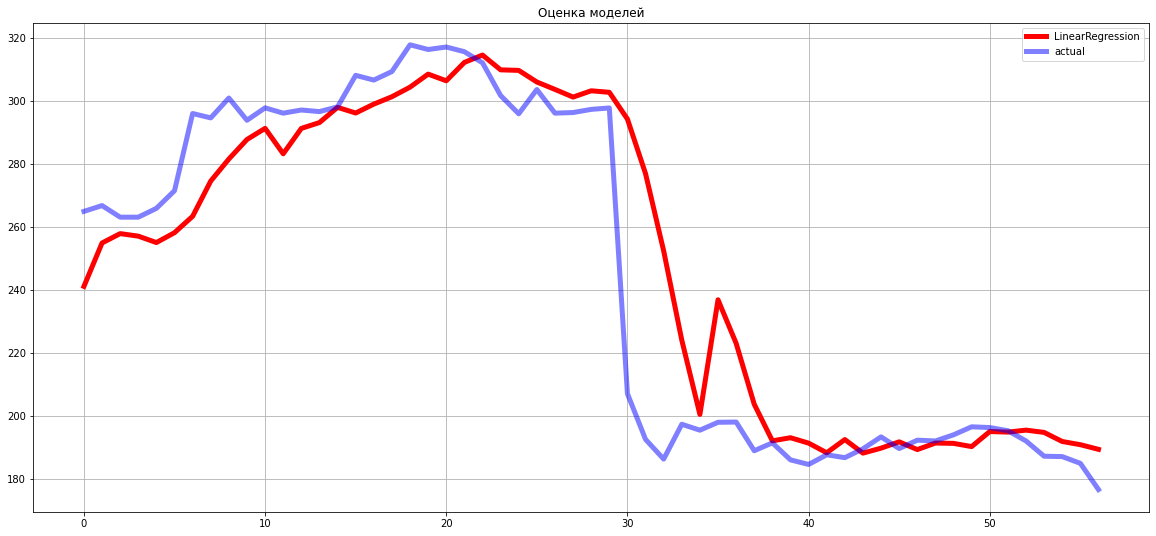

In [21]:
# Зададим индекс
quotes = pd.read_table('https://raw.githubusercontent.com/RMA1011/da_hw/main/ML/HW2/GAZP_210801_220806.txt', header = 0, sep = ',', parse_dates = ['<DATE>'])
quotes.set_index('<DATE>', inplace = True)
quotes.sort_index(inplace = True)
print('Монотонность - ',quotes.index.is_monotonic)

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.isin([5,6])*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['<CLOSE>'].shift(lag)

    data['price_mean'] = data['<CLOSE>'].shift().rolling(rolling_mean_size).mean().copy()

make_features(quotes, 10, 7)

quotes.dropna(inplace = True)

# нужно выбрать отдельные факторы, боимся мультиколлинеарности
features = quotes[['lag_5','price_mean']]
target = quotes['<CLOSE>']
X_train,X_test,y_train, y_test = train_test_split(features,target, shuffle=False, test_size=0.25)
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
y_predicted_lr = model_lr.predict(X_test)
print("RMSE тестовой выборки LinearRegression: ",np.sqrt(mean_squared_error(y_test, y_predicted_lr)))
plt.figure(figsize=(20, 9))
plt.plot(y_predicted_lr, "r",linewidth=5, label="LinearRegression")
plt.plot(y_test.values,'b' ,label="actual", linewidth=5, alpha = 0.5)
plt.legend(loc="best")
plt.title("Оценка моделей")
plt.grid(True)



In [67]:
X_for_predict = quotes[['<CLOSE>','lag_5','price_mean']].copy()
X_for_predict.loc[pd.to_datetime('2022-08-06')] = [0,0,0]
make_features(X_for_predict, 10, 7)
features_for_predict = X_for_predict[['lag_5','price_mean']]
features_for_predict.dropna(inplace = True)
prediction = model_lr.predict(features_for_predict)
prediction = pd.DataFrame(data = prediction, columns = ['Прогнозная цена'], index = features_for_predict.index)
last_day = prediction.index[-1]
last_price = prediction.loc[last_day,'Прогнозная цена']
print('Прогнозная цена на {0} составляет {1} USD'.format(last_day.strftime('%d.%m.%Y'),np.round(last_price,0)))
print('')
print('----------------------------------------------------------------------')

Прогнозная цена на 06.08.2022 составляет 187.0 USD

----------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq_ydyf4c/7shhskrr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq_ydyf4c/lgz0b_1u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65224', 'data', 'file=/tmp/tmpq_ydyf4c/7shhskrr.json', 'init=/tmp/tmpq_ydyf4c/lgz0b_1u.json', 'output', 'file=/tmp/tmp_y619pfw/prophet_model-20220809193928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:39:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:39:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


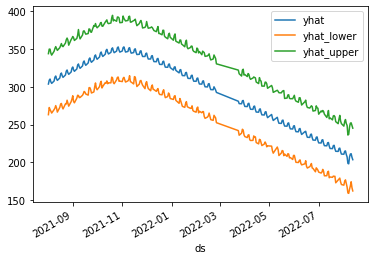

In [69]:
## Пророчим!

m = Prophet()
quotes = pd.read_table('https://raw.githubusercontent.com/RMA1011/da_hw/main/ML/HW2/GAZP_210801_220806.txt', header = 0, sep = ',', parse_dates = ['<DATE>'])
quotes.set_index('<DATE>', inplace = True)
quotes.sort_index(inplace = True)
quotes_prophet = quotes[['<CLOSE>']].reset_index()
quotes_prophet.columns = ['ds','y']
m.fit(quotes_prophet)
future = m.make_future_dataframe(periods=7)
future.tail()
forecast = m.predict(future)
forecast.set_index('ds',inplace=True)
forecast[[ 'yhat', 'yhat_lower', 'yhat_upper']].plot()


In [77]:
forecast.loc[pd.to_datetime('2022-08-06'), ['yhat','yhat_lower','yhat_upper']]

yhat_predicted = forecast.loc[pd.to_datetime('2022-08-06'), 'yhat']
yhat_lower_predicted = forecast.loc[pd.to_datetime('2022-08-06'), 'yhat_lower']
yhat_upper_predicted = forecast.loc[pd.to_datetime('2022-08-06'), 'yhat_upper']
print('Прогнозная цена по Prophet на {0} составляет {1} USD и лежит в интервале от {2} до {3}'.format(last_day.strftime('%d.%m.%Y'),np.round(yhat_predicted,0),np.round(yhat_lower_predicted,0),np.round(yhat_upper_predicted,0)))

Прогнозная цена по Prophet на 06.08.2022 составляет 199.0 USD и лежит в интервале от 160.0 до 236.0
